# Classification with FNO
Train an FNO timeseries classifier on the FordA dataset from the UCR/UEA archive.

Much of this comes from the following Keras tutorial: https://keras.io/examples/timeseries/timeseries_classification_from_scratch/

The dataset we are using here is called FordA. The data comes from the UCR archive. The dataset contains 3601 training instances and another 1320 testing instances. Each timeseries corresponds to a measurement of engine noise captured by a motor sensor. For this task, the goal is to automatically detect the presence of a specific issue with the engine. The problem is a balanced binary classification task. The full description of this dataset can be found here: http://www.j-wichard.de/publications/FordPaper.pdf

Later, can include the features mentioned in the paper; namely the autocorrelation values and spectral density features as separate channels, akin to the work we will do later

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, ExponentialLR
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from lightning import LightningModule, Trainer
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
import datetime
import optuna
from sklearn.metrics import roc_curve, auc

## Load the data

In [15]:
# Read the data
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)

root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

Class -1 explained variance: 0.9293035517000288
Class 1 explained variance: 0.9531240566691049


/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/fno/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/fno/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


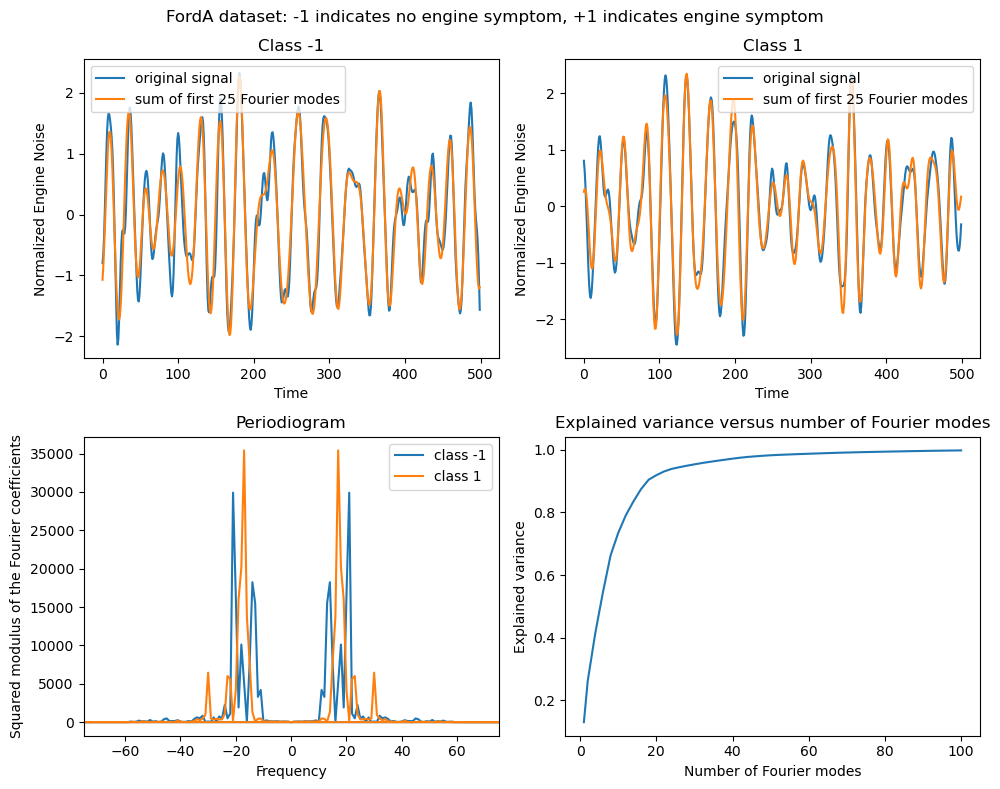

In [16]:
# Visualize the data and periodiogram in 1 figure
classes = np.unique(np.concatenate((y_train, y_test), axis=0))
n = x_train.shape[1]
fourier_modes = 25

plt.figure(figsize=(10, 8))
plt.suptitle('FordA dataset: -1 indicates no engine symptom, +1 indicates engine symptom')

# Plot the original vs. the sum of the first most dominant fourier_modes 
# modes of the Fourier series for each class
for i, c in enumerate(classes, 1):
    plt.subplot(2, 2, i)  # 2 rows, 2 columns, i-th plot
    c_x_train = x_train[y_train == c]
    fourier_series = np.fft.fft(c_x_train)[0]
    
    # Get the indices of the 4 largest Fourier coefficients
    fourier_modes_indices = np.abs(fourier_series).argsort()[-fourier_modes:]
    
    # Set all other coefficients to zero
    dominant_modes = np.zeros_like(fourier_series)
    dominant_modes[fourier_modes_indices] = fourier_series[fourier_modes_indices]
    
    # Perform an inverse Fourier transform
    inverse_transform = np.fft.ifft(dominant_modes)

    print("Class", c, "explained variance:", np.var(inverse_transform) / np.var(c_x_train))
    
    plt.plot(c_x_train[0], label="original signal")
    plt.plot(inverse_transform, label=f"sum of first {fourier_modes} Fourier modes")
    plt.legend(loc="best")
    plt.xlabel('Time')
    plt.ylabel('Normalized Engine Noise')
    plt.title(f'Class {c}')

# Plot the periodiogram
plt.subplot(2, 2, 3)  # 2 rows, 2 columns, third plot
for c in classes:
    c_x_train = x_train[y_train == c]
    periodiogram = np.abs(np.fft.fft(c_x_train)[0]) ** 2
    plt.plot(np.fft.fftfreq(n, 1 / n), periodiogram, label="class " + str(c))
plt.legend(loc="best")
plt.xlim(-75, 75)
plt.xlabel('Frequency')
plt.ylabel('Squared modulus of the Fourier coefficients')
plt.title('Periodiogram')

# Plot the explained variance versus fourier modes
plt.subplot(2, 2, 4)  # 2 rows, 2 columns, fourth plot
explained_variance = []
num_modes_range = range(1, 101)
for fourier_modes in num_modes_range:
    explained_variance.append(0)
    for c in classes:
        c_x_train = x_train[y_train == c]
        fourier_series = np.fft.fft(c_x_train)[0]
        fourier_modes_indices = np.abs(fourier_series).argsort()[-fourier_modes:]
        dominant_modes = np.zeros_like(fourier_series)
        dominant_modes[fourier_modes_indices] = fourier_series[fourier_modes_indices]
        inverse_transform = np.fft.ifft(dominant_modes)
        explained_variance[-1] += np.var(inverse_transform) / np.var(c_x_train)
    explained_variance[-1] /= len(classes)

plt.plot(num_modes_range, explained_variance)
plt.xlabel('Number of Fourier modes')
plt.ylabel('Explained variance')
plt.title('Explained variance versus number of Fourier modes')

plt.tight_layout()
plt.show()

In [17]:
# Reshape the data to be ready for multivariate time-series data (multiple channels)
# Shape is (samples, channels, sequence length)
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print("x_train shape: ", x_train.shape)
print("x_test shape: ", x_test.shape)

# Count the number of classes
num_classes = len(np.unique(y_train))
print("Number of classes: " + str(num_classes))

# Standardize the labels to positive integers. The expected labels will then be 0 and 1.
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

# Use 20% of training data for validation
train_set_size = int(len(x_train) * 0.8)
valid_set_size = len(x_train) - train_set_size
print("Training set size: " + str(train_set_size))
print("Validation set size: " + str(valid_set_size))

# split the x_train and y_train set into two
seed = torch.Generator().manual_seed(42)
x_train, x_valid = data.random_split(x_train, [train_set_size, valid_set_size], generator=seed)
y_train, y_valid = data.random_split(y_train, [train_set_size, valid_set_size], generator=seed)

x_train shape:  (3601, 1, 500)
x_test shape:  (1320, 1, 500)
Number of classes: 2
Training set size: 2880
Validation set size: 721


In [18]:
# Create train, valid, and test data loaders with float64 datatype
batch_size = 32
workers = 1
train_loader = DataLoader(
    list(zip(x_train, y_train)),
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=workers,
)

valid_loader = DataLoader(
    list(zip(x_valid, y_valid)),
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    num_workers=workers,
)

test_loader = DataLoader(
    list(zip(x_test, y_test)),
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    num_workers=workers,
)

# Print the size of a batch and type of data
for x, y in train_loader:
    print("Sample batch of data (batch size, # channels, sequence length): " + str(x.shape))
    break

Sample batch of data (batch size, # channels, sequence length): torch.Size([32, 1, 500])


## FNO Model

In [19]:
# Option 1: use neuralop package
# from neuralop.models.spectral_convolution import FactorizedSpectralConv
# fourier_layer = FactorizedSpectralConv(in_channels=in_channels, out_channels=out_channels, n_modes=(modes1))

# Option 2: create my own spectral convolution layer
class SpectralConv1d(nn.Module):
    def __init__(self,
                 in_channels,   # Number of input channels
                 out_channels,  # Number of output channels
                 modes,         # Number of Fourier modes to multiply, at most floor(N/2) + 1
                 debug=False):  # If true, print the shape of every parameter      
        super(SpectralConv1d, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes
        self.debug = debug

        self.scale = (1 / (in_channels * out_channels))
        self.weights = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes, dtype=torch.cfloat))

    def forward(self, x):
        batchsize = x.shape[0]

        #Compute Fourier coefficients
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        
        if self.debug:
            print("x shape: " + str(x.shape))
            print("x_ft.shape: " + str(x_ft.shape))
            print("out_ft.shape: " + str(out_ft.shape))
            print("self.weights.shape: " + str(self.weights.shape))

        out_ft[:, :, :self.modes] = \
            self.compl_mul1d(x_ft[:, :, :self.modes], self.weights)

        #Return to physical space
        x = torch.fft.irfft(out_ft)

        if self.debug:
            print("irfft out_ft shape: " + str(x.shape) + "\n")
        
        return x

    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

In [20]:
class FNOClassifier(LightningModule):
    def __init__(self, 
                 modes, 
                 lr=1e-3, 
                 channels=[64, 64, 64], 
                 pooling=500, 
                 optimizer="adam", 
                 scheduler="reducelronplateau", 
                 momentum=0.9,
                 pool_type="max"
        ):
        super().__init__()

        self.lr = lr
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.momentum = momentum
        self.num_channels = len(channels)
        self.loss = nn.CrossEntropyLoss()

        self.example_input_array = torch.rand(1, 1, 500)

        for i in range(self.num_channels):
            if i == 0:
                in_channels = 1
            else:
                in_channels = channels[i-1]

            out_channels = channels[i]

            setattr(self, f"fno_layer_{i}", nn.Sequential(
                SpectralConv1d(in_channels, out_channels, modes),
                nn.BatchNorm1d(out_channels)
            ))
        
        if pool_type == "max":
            self.pool = nn.MaxPool1d(pooling)
        else:
            self.pool = nn.AvgPool1d(pooling)

        self.fc = nn.Linear(channels[-1] * int((500/pooling)), 2) # output number of channels of final fno_block * (3rd input dimension 500 / maxpool size)

    def forward(self, x):
        for i in range(self.num_channels):
            x = getattr(self, f"fno_layer_{i}")(x)
            x = F.tanh(x)

        x = self.pool(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x    

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = self.forward(x)

        # Log the loss
        loss = self.loss(x, y) # No need for softmax, as it is included in nn.CrossEntropyLoss
        self.log("train_loss", loss)

        # Log the accuracy
        logits = F.softmax(x, dim=1)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log("train_acc", acc)

        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = self.forward(x)

        # Log the loss
        loss = self.loss(x, y)
        self.log("val_loss", loss)
        
        # Log the accuracy
        logits = F.softmax(x, dim=1)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log("val_acc", acc)

        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        x = self.forward(x)

        # Log the loss
        loss = self.loss(x, y)
        self.log("test_loss", loss)

        # Log the accuracy
        logits = F.softmax(x, dim=1)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log("test_acc", acc)

        return loss
    
    def configure_optimizers(self):
        if self.optimizer == "sgd":
            optimizer = torch.optim.SGD(self.parameters(), lr=self.lr, momentum=self.momentum)
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)

        if self.scheduler == "reducelronplateau":
            scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5, min_lr=1e-6)
        elif self.scheduler == "cosineannealinglr":
            scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)
        else:
            scheduler = ExponentialLR(optimizer, gamma=0.95)
        
        return [optimizer], [{"scheduler": scheduler, "monitor": "val_loss"}]

## Train and test a model

In [21]:
# Hyperparameters
modes = 25 
channels = [8192] 
pool_type = "avg" 
pooling = 500

# Optimizers and learning rate schedulers
optimizer = "adam"
momentum = 0 
scheduler = "cosineannealinglr"
lr = 1e-3

# Initialize classifier
classifier = FNOClassifier(modes=modes, lr=lr, channels=channels, pooling=pooling, optimizer=optimizer, scheduler=scheduler, momentum=momentum, pool_type=pool_type)

# Print the model
print(classifier.eval())

FNOClassifier(
  (loss): CrossEntropyLoss()
  (fno_layer_0): Sequential(
    (0): SpectralConv1d()
    (1): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool): AvgPool1d(kernel_size=(500,), stride=(500,), padding=(0,))
  (fc): Linear(in_features=8192, out_features=2, bias=True)
)


In [26]:
# Create a learning rate scheduler and early stopping callback
callbacks = [
    # EarlyStopping(monitor="val_acc", patience=30, mode="max"),
    LearningRateMonitor(logging_interval="step")
]

# Create a tensorboard logger
experiment_name = "fitting_train_trying_to_generalize"
save_directory = "logs/"

# Check if save_dir/experiment_name exists, if not create it
if not os.path.exists(save_directory + experiment_name):
    os.makedirs(save_directory + experiment_name)

logger = TensorBoardLogger(save_dir=save_directory, name=experiment_name, version=datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S"))
logger.log_hyperparams({
    "modes": modes, 
    "lr": lr, 
    "channels": channels,
    "pool_type": pool_type, 
    "pooling": pooling, 
    "lr_scheduler": scheduler, 
    "batchsize": batch_size, 
    "optimizer": optimizer, 
    "momentum": momentum
})
print("Tensorboard logs will be saved to: " + logger.log_dir)

# Train the model
trainer = Trainer(max_epochs=500,
                  logger=logger,
                  callbacks=callbacks,
                  accelerator="auto",
                  log_every_n_steps=10,
                #   overfit_batches=1
)

trainer.fit(model=classifier, 
            train_dataloaders=train_loader,
            val_dataloaders=valid_loader
)

Tensorboard logs will be saved to: logs/fitting_train_trying_to_generalize/2024_03_04-22_43_22


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
# Test the model
trainer.test(dataloaders=test_loader)

In [ ]:
# Get the predictions
y_pred = []
y_true = []

for x, y in test_loader:
    x = x.to(classifier.device)
    y = y.to(classifier.device)
    logits = F.softmax(classifier(x), dim=1)
    preds = torch.argmax(logits, dim=1)
    y_pred.extend(logits.cpu().detach().numpy())
    y_true.extend(y.cpu().detach().numpy())

# Compute the ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")


# Save the figure to the logs directory
plt.savefig(logger.log_dir + "/roc_curve.png")

## Optuna

In [ ]:
# # Create an optuna study to optimize the number of modes, channels, and pooling size
# def objective(trial):
#     # Optimize the number of modes
#     modes = trial.suggest_int("modes", 5, 15)

#     # Optimize the number of fno_layers
#     fno_layers = trial.suggest_int("fno_layers", 2, 5)

#     # Optimize the number of channels
#     channels = [trial.suggest_int(f"n_channels_{i}", 16, 256) for i in range(fno_layers)]

#     # Optimize the pooling size
#     pooling = trial.suggest_int("pooling", 2, 500)

#     # Optimize the learning rate
#     lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)

#     # Create the model
#     model = FNOClassifier(modes=modes, channels=channels, pooling=pooling)

#     # Create a learning rate scheduler and early stopping callback
#     callbacks = [
#         EarlyStopping(monitor="val_acc", patience=20, mode="max"),
#         LearningRateMonitor(logging_interval="step")
#     ]

#     # Create a tensorboard logger
#     experiment_name = "optuna"
#     logger = TensorBoardLogger(save_dir="logs/", name=experiment_name, version=datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S"))

#     logger.log_hyperparams({"modes": modes, "lr": lr, "channels": channels, "pooling": pooling, "lr_scheduler": "ReduceLROnPlateau", "patience": 10, "min_lr": 1e-6, "factor": 0.5, "batchsize": batch_size})

#     # Create a trainer
#     trainer = Trainer(
#         max_epochs=100,
#         logger=logger,
#         callbacks=callbacks,
#         accelerator='auto'
#     )

#     # Train the model
#     trainer.fit(model, train_loader, valid_loader)

#     # Test the model
#     result = trainer.test(dataloaders=test_loader)

#     # Return the validation accuracy
#     return result[0]["test_acc"]

In [ ]:
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=500)

# # Print the best hyperparameters
# print(study.best_params)